In [1]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"
GEOMETRY_Source = f"{project_root_dir}/datasets/QM9/xyz_c7h10o2_sorted"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Project root directory: /home/ewachmann/REPOS/Masterarbeit
Using device: cuda


In [ ]:
MGNN = MolGraphNetwork(xyz_source=GEOMETRY_Source,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=16,
                       hidden_dim=256,
                       train_val_test_ratio=(0.8, 0.1, 0.1), 
                       message_passing_steps=3,
                       edge_threshold_val=5,
                       message_net_layers=3,
                       message_net_dropout=0.1,
                       target="density",
                       data_aug_factor=1,
                       verbose_level=2)
MGNN.load_data(max_samples=500,
               cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": f"{project_root_dir}/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"})

Setting verbose level to: 2
Loading 6095 files from /home/ewachmann/REPOS/Masterarbeit/datasets/QM9/xyz_c7h10o2_sorted...
Limiting to 500 samples out of 6095 total files.


Loading files: 100%|██████████| 500/500 [00:00<00:00, 593.46it/s]
Creating graphs: 17it [00:00, 27.90it/s]

In [ ]:
RETRAIN = False
model_name = "MGNN_6-31G_simple_AUG"
if not RETRAIN and os.path.exists(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth"):
    MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")
else:
    MGNN.train_model(num_epochs=100, lr=1e-3, weight_decay=1e-5, model_save_path=f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")
    MGNN.save_model(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.pth")

Epoch 1 [Train]: 100%|██████████| 25/25 [00:26<00:00,  1.07s/it]


Epoch 1/100 → Avg Train Loss: 211.896562


Epoch 1 [Val]: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Epoch 1/100 → Avg Val   Loss: 138.477680
Model checkpoint saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 2 [Train]: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


Epoch 2/100 → Avg Train Loss: 116.387729


Epoch 2 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.56it/s]


Epoch 2/100 → Avg Val   Loss: 105.881334
Model checkpoint saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 3 [Train]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


Epoch 3/100 → Avg Train Loss: 100.094250


Epoch 3 [Val]: 100%|██████████| 4/4 [00:00<00:00,  4.46it/s]


Epoch 3/100 → Avg Val   Loss: 100.251665
Model checkpoint saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 4 [Train]: 100%|██████████| 25/25 [00:28<00:00,  1.14s/it]


Epoch 4/100 → Avg Train Loss: 94.916205


Epoch 4 [Val]: 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]


Epoch 4/100 → Avg Val   Loss: 96.358286
Model checkpoint saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


Epoch 5 [Train]:   0%|          | 0/25 [00:01<?, ?it/s]


Training interrupted by user. Benchmark...


Epoch 5 [Test]: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

Test  Loss: 91.968079
Model saved to /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/models/MGNN_6-31G_simple_AUG.pth


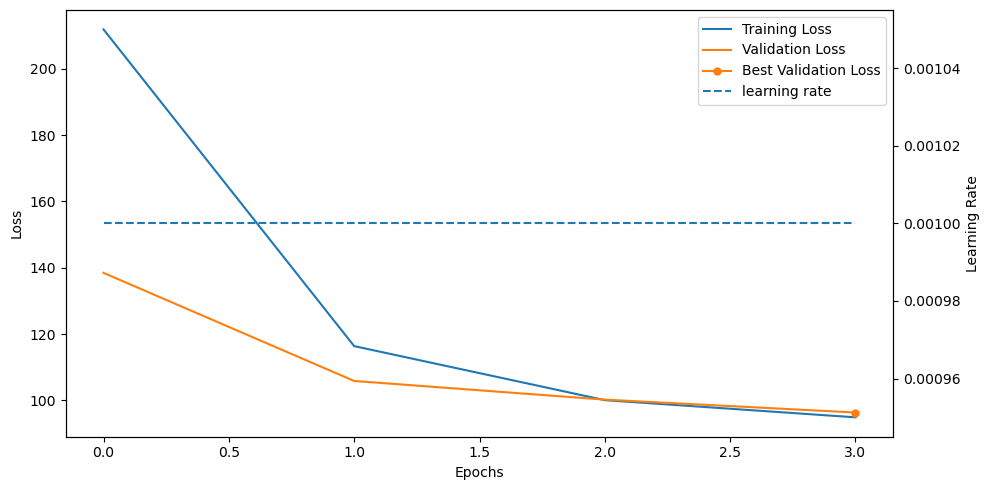

In [ ]:
import pickle
from matplotlib import pyplot as plt
with open(f"{project_root_dir}/3_studies/Block_guessing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [ ]:
test_graphs = MGNN.get_graphs("test")

In [ ]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]

Testing on random sample with id 43


In [8]:
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_pred, density_truth, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_pred[:10,:10], density_truth[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

ok this already look pretty good for very few training runs!

In [ ]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [ ]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

In [ ]:
density_pred = density_pred.astype(np.float64)

In [ ]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_pred)

In [ ]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_truth)

In [ ]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

In [ ]:
plot_mat_comp(wf_minao._D, 2*density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

# Iteration Benchmark

In [ ]:
from time import time
from uncertainties import ufloat

In [ ]:
start_time = time()
density_preds = MGNN.predict(test_graphs, include_target=True, transform_to_density=True)
pred_time = time() - start_time # stat benchmarking later
print(f"Prediction time for {len(test_graphs)} samples: {pred_time:.2f} seconds - {pred_time/len(test_graphs):.4f} seconds per sample")

files = MGNN.get_files("test")
print(f"Number of test files: {len(files)}")

cycles = {"minao": [], "gnn": []}
print("Testing for iteration count")

In [ ]:
# own 
for i, (file, density_pred) in enumerate(zip(files, density_preds)):
    mol = load(file, basis=BASIS_PATH, backend=Backend.PY)
    wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=2*density_pred[0])
    cycles["gnn"].append(wf_own.native.cycles)
    print(f"Sample {i}: Cycles with own guess: {wf_own.native.cycles}")


In [ ]:
# minao
for i, file in enumerate(files):
    mol = load(file, basis=BASIS_PATH, backend=Backend.PY)
    wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")
    cycles["minao"].append(wf_minao.native.cycles)
    print(f"Sample {i}: Cycles with minao guess: {wf_minao.native.cycles}")

In [ ]:
cutoff = 45
mean_own = np.mean(cycles["gnn"][:cutoff])
std_own = np.std(cycles["gnn"][:cutoff])
iter_own = ufloat(mean_own, std_own)
mean_minao = np.mean(cycles["minao"][:cutoff])
std_minao = np.std(cycles["minao"][:cutoff])
iter_minao = ufloat(mean_minao, std_minao)
print(f"Average iterations with own guess: {iter_own:.2f}, with minao guess: {iter_minao:.2f}")

#### look into difference of truth vs. recalc!

In [ ]:
import sys
sys.path.append('../src/')
from utils import density_fock_overlap
test_file = os.path.join(GEOMETRY_Source, "dsgdb9nsd_082759.xyz")
print(test_file)



In [ ]:
mol = load(test_file, basis=BASIS_PATH, backend=Backend.PY)
minao_calc = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")


In [ ]:

cache_meta = {"method":"dft", "basis":None, "functional": "b3lypg", "guess": "minao", "backend": "pyscf", "cache": "/home/etschgi1/REPOS/Masterarbeit/datasets/QM9/out/c7h10o2_b3lypg_6-31G(2df,p)_sorted/pyscf"}
mol_name = os.path.basename(test_file).strip()
cached_truth = density_fock_overlap(filepath=test_file,
                                              filename = mol_name,
                                              method = cache_meta["method"],
                                              basis = None,
                                              functional = cache_meta["functional"],
                                              guess = cache_meta["guess"],
                                              backend = cache_meta["backend"],
                                              cache = cache_meta["cache"])
density_cached_truth = cached_truth[0].numpy
plot_mat_comp(minao_calc.density().numpy, density_cached_truth, title="Guess (using truth as guess)", ref_title="Minao guess", pred_title="Truth from prev. calculation", vmax=0.1)